# This notebook
- builds a toy dataset with one highly discriminatory feature
- confirms that `lrp` picks up the discriminatory feature as highly relevant
- compares the `lrp` implemented in `captum` against farouk's implementation

In [8]:
import pickle as pkl
import os.path as osp
import os
import sys
from glob import glob
from lrp.explainer import FFN, LRP

import captum.attr
import random

import numpy as np
import mplhep as hep
import pandas as pd

import torch
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.data import Data, DataLoader, DataListLoader, Batch
%matplotlib inline

device = 'cpu'

In [9]:
# build toy dataset
# only 2 classes (binary classification)
class1_y = np.zeros([1000, 1])
class2_y = np.ones([1000, 1])

# model should pick feature # 2 as the discriminant feature (more relevant)
class1_x1 = np.random.uniform(low=0.0, high=1.0, size=1000)
class2_x1 = np.random.uniform(low=0.0, high=1.0, size=1000)

class1_x2 = np.random.uniform(low=0.0, high=1.0, size=1000)
class2_x2 = np.random.uniform(low=-1.0, high=0.0, size=1000)

class1_x3 = np.random.uniform(low=0.0, high=1.0, size=1000)
class2_x3 = np.random.uniform(low=0.0, high=1.0, size=1000)

# build loaders
x1_all = np.concatenate([class1_x1, class2_x1]).reshape(-1, 1)
x2_all = np.concatenate([class1_x2, class2_x2]).reshape(-1, 1)
x3_all = np.concatenate([class1_x3, class2_x3]).reshape(-1, 1)

y_all = np.concatenate([class1_y, class2_y]).reshape(-1, 1)

dataset = np.concatenate([x1_all, x2_all, x3_all, y_all], axis=1)
np.random.shuffle(dataset)

dataset = torch.from_numpy(dataset)
train_dataset = dataset[:1500]
valid_dataset = dataset[1500:]

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True)

/opt/anaconda3/envs/xai/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
# notice feature 2 is the discriminatory feature
# it's positive for class 0 and negative for class 1
for batch in train_loader:
    df = pd.DataFrame({'feature1': batch[:, 0], 'feature2': batch[:, 1], 'feature3': batch[:, 2], 'class': batch[:, 3]})
    print(df)
    break

   feature1  feature2  feature3  class
0  0.124479 -0.976161  0.756241    1.0
1  0.251389 -0.906430  0.049930    1.0
2  0.443295  0.003877  0.254613    0.0
3  0.405496  0.398705  0.629747    0.0


In [11]:
model = FFN()
model.train()

FFN(
  (nn1): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=40, bias=True)
  )
  (nn2): Sequential(
    (0): Linear(in_features=43, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [12]:
def train(model, epochs):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    losses, accuracies = [], []
    losses_val, accuracies_val = [], []

    for epoch in range(epochs):
        print(f'Epoch {epoch}')
        losses_batch, accuracies_batch = [], []
        losses_batch_val, accuracies_batch_val = [], []

        model.train()
        for i, batch in enumerate(train_loader):
            X = batch[:, :-1]
            Y = batch[:, -1]

            # Forwardprop
            preds = model(X.float())

            loss = torch.nn.functional.cross_entropy(preds.float(), Y.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses_batch.append(loss.detach().cpu().item())
            accuracies_batch.append(accuracy_score(Y, preds.max(axis=1).indices))
        losses.append(np.mean(losses_batch))
        accuracies.append(np.mean(accuracies_batch))

        model.eval()
        for i, batch in enumerate(valid_loader):
            X = batch[:, :-1]
            Y = batch[:, -1]

            # Forwardprop
            preds = model(X.float())

            loss_val = torch.nn.functional.cross_entropy(preds.float(), Y.long())

            losses_batch_val.append(loss_val.detach().cpu().item())
            accuracies_batch_val.append(accuracy_score(Y, preds.max(axis=1).indices))

        losses_val.append(np.mean(losses_batch_val))
        accuracies_val.append(np.mean(accuracies_batch_val))
    torch.save(model.state_dict(), "weights.pth")
    return losses, accuracies, losses_val, accuracies_val

losses, accuracies, losses_val, accuracies_val = train(model, 10)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


Text(0.5, 0, 'epoch')

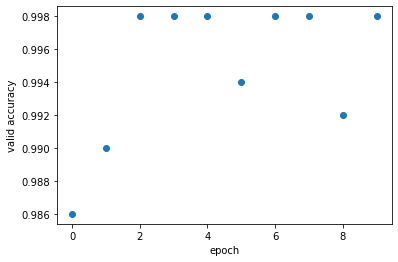

In [13]:
plt.scatter(np.arange(0, len(accuracies_val)), accuracies_val)
plt.ylabel("valid accuracy")
plt.xlabel("epoch")

## Captum's `lrp`

In [14]:
# load the trained model for lrp
model = FFN()
state_dict = torch.load("weights.pth", map_location=device)
model.load_state_dict(state_dict)

lrp_model = captum.attr.LRP(model)

In [23]:
# get R_scores for output node 0
R_captum = lrp_model.attribute(valid_dataset[:, :-1].float(), target=0)

In [25]:
R_captum.shape   ### 500 for the number of samples, 3 for the input features

torch.Size([500, 3])

In [65]:
R_captum

tensor([[-1.1746e-02,  9.7916e+00, -7.0045e-01],
        [-1.1673e-01,  1.5588e+01, -5.8463e-02],
        [-3.5186e-01, -1.6327e+01,  8.3645e-01],
        ...,
        [-1.4744e-01,  1.2204e+01, -4.6624e-01],
        [-5.3504e-05, -2.4148e+01,  4.0499e-01],
        [-1.2131e-01,  2.4652e+01, -2.2948e-02]], grad_fn=<MulBackward0>)

## Farouk's `lrp`

In [26]:
# load the trained model
model = FFN()
state_dict = torch.load("weights.pth", map_location=device)
model.load_state_dict(state_dict)
    
lrp_instance = LRP(device, model, epsilon=1e-9)
R_farouk = lrp_instance.explain(valid_dataset[:, :-1].float(), neuron_to_explain=0)

Total number of layers (including activation layers): 8
Explaining layer 1/8: Linear(in_features=256, out_features=2, bias=True)
- Finished computing Rscores
- Rscores are conserved up to relative tolerance 1e-05
Explaining layer 2/8: ReLU()
- skipping layer because it's an activation layer
- Rscores do not need to be computed
Explaining layer 3/8: Linear(in_features=43, out_features=256, bias=True)
- Finished computing Rscores
- Rscores are conserved up to relative tolerance 1e-05
SKIP CONNECTION LAYER
Explaining layer 4/8: Linear(in_features=256, out_features=40, bias=True)
- Finished computing Rscores
- Rscores are conserved up to relative tolerance 1e-05
Explaining layer 5/8: ReLU()
- skipping layer because it's an activation layer
- Rscores do not need to be computed
Explaining layer 6/8: Linear(in_features=256, out_features=256, bias=True)
- Finished computing Rscores
- Rscores are conserved up to relative tolerance 1e-05
Explaining layer 7/8: ReLU()
- skipping layer because it's

In [27]:
# R_scores for output node 0
R_farouk.shape

torch.Size([500, 3])

In [66]:
R_farouk

tensor([[-7.3677e-01,  1.0997e+01,  1.1113e+00],
        [-5.3716e-01,  2.0648e+01, -9.9231e-01],
        [-2.0605e-01, -1.5387e+01, -4.5423e+00],
        ...,
        [ 1.5187e+01, -1.3995e+01,  1.3161e+01],
        [ 3.2644e-03, -2.9882e+01,  9.7588e-01],
        [-5.4253e-01,  3.0380e+01, -1.8063e+00]])

# Comparison between Captum and Farouk

<b>notice</b>: actual Rscores per sample are different

In [68]:
sample = 0
print('R_captum', R_captum[sample].absolute().detach())
print('R_farouk', R_farouk[sample].absolute())

R_captum tensor([0.0117, 9.7916, 0.7005])
R_farouk tensor([ 0.7368, 10.9967,  1.1113])


In [69]:
# taking mean over samples
print('R_captum', R_captum.absolute().sum(axis=0).detach())
print('R_farouk', R_farouk.absolute().sum(axis=0))

R_captum tensor([ 150.3610, 8222.4287,  269.6331])
R_farouk tensor([ 7206.3384, 18295.0840,  5705.6211])


<b>notice</b>: R_captum and R_farouk have second feature as highly relevant

In [58]:
# define normalization function that normalizes a given R~(500,3) over the 3 features (i.e. over dim=1)
def norm(R):
    return R/R.sum(axis=0)

In [72]:
# normalize over features
print('R_captum', norm(R_captum.absolute().sum(axis=0).detach()))
print('R_farouk', norm(R_farouk.absolute().sum(axis=0).detach()))

R_captum tensor([0.0174, 0.9514, 0.0312])
R_farouk tensor([0.2309, 0.5862, 0.1828])


## Let's now check R-score conservation

In [75]:
preds = model(valid_dataset[:, :-1].float())

sample = 12
print('R_input_captum' , R_captum[sample].sum().item())
print('R_input_farouk' , R_farouk[sample].sum().item())
print('R_output      ', preds[sample][0].item())

R_input_captum 10.808303833007812
R_input_farouk 13.194891929626465
R_output       13.194897651672363


<b>notice</b>: farouk's lrp implementation conerves Rscores

## More comparisons

Text(0.5, 1.0, 'Resolution of the second feature')

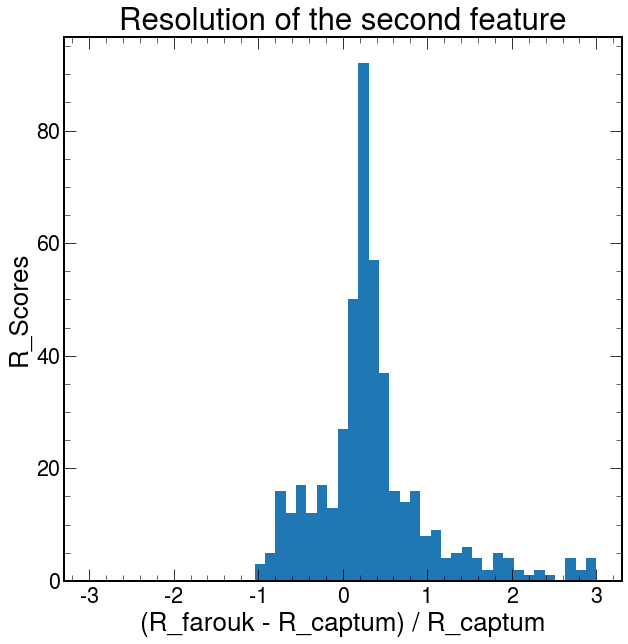

In [63]:
# compute resolution for feature # 2 for output node 0
Rf =  R_farouk[:, 1].absolute().detach()
Rc = R_captum[:, 1].absolute().detach()

res = (Rf - Rc)/ Rc
plt.style.use(hep.style.ROOT)
plt.hist(res, np.linspace(-3,3));
plt.ylabel('R_Scores')
plt.xlabel('(R_farouk - R_captum) / R_captum')
plt.title('Resolution of the second feature')

Text(0.5, 1.0, 'Resolution of second feature \n after normalization')

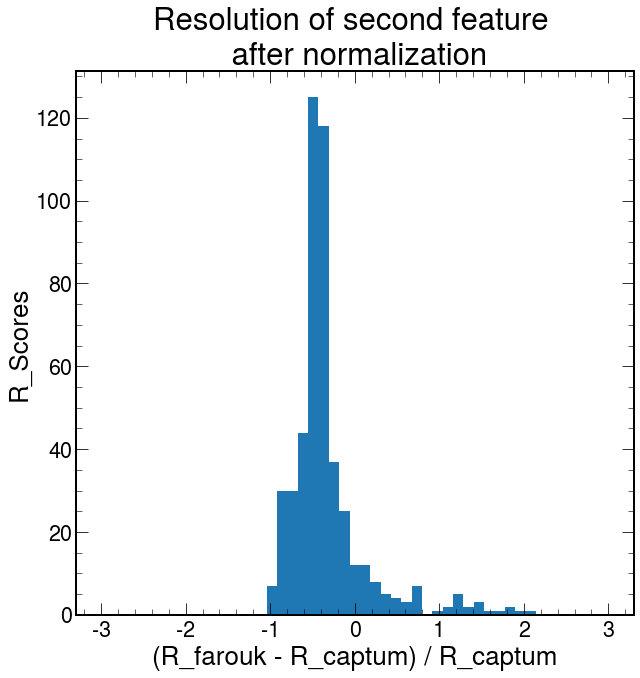

In [64]:
# normalizing first
Rf = norm(R_farouk.absolute().detach())[:, 1]
Rc = norm(R_captum.absolute().detach())[:, 1]

# compute resolution for feature # 2 for output node 0
res = (Rf - Rc) / Rc
plt.style.use(hep.style.ROOT)
plt.hist(res, np.linspace(-3,3));
plt.ylabel('R_Scores')
plt.xlabel('(R_farouk - R_captum) / R_captum')
plt.title('Resolution of second feature \n after normalization')

## Conclusion:
- `lrp` by captum and `lrp` by farouk give similar but not exact results
- we notice that farouk's implementation conserves Rscores better than captum's
- we notice that farouk's implementation is a little slower which suggests that captum's implementation might be using faster approximate methods yielding slightly inexact results

### Notes:
- I have further tested this for a bigger toy dataset with more than one discrimantory feature and the conclusion is almost the same